In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) to sys.path


In [2]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd

from data_loading import DataPreprocessor
from mood_RNN_classifier import RNNClassifier, MoodDataset, OrdinalLabelSmoothingLoss, split_train_val, objective, train_epoch, train_final_model, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_loader = DataPreprocessor()
train_df, test_df = data_loader.load_and_preprocess_data("1d")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df['id'].unique())}
input_dim = train_df.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)
output_dim = train_df['mood'].max() + 1

train_df_split, val_df_split = split_train_val(train_df, fraction=0.2)

In [5]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, output_dim, device), n_trials=200)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-17 20:37:04,691] A new study created in memory with name: no-name-85b43180-378f-4c0e-b075-dc9d4924e46a
[I 2025-04-17 20:37:09,868] Trial 0 finished with value: 0.22316743433475494 and parameters: {'hidden_dim': 63, 'id_embed_dim': 5, 'lr': 0.0049639865353721425, 'batch_size': 64, 'alpha': 0.04456595327275025}. Best is trial 0 with value: 0.22316743433475494.
[I 2025-04-17 20:37:09,994] Trial 1 finished with value: 0.5566116571426392 and parameters: {'hidden_dim': 57, 'id_embed_dim': 16, 'lr': 0.0016419874840177464, 'batch_size': 128, 'alpha': 0.10412491869201401}. Best is trial 0 with value: 0.22316743433475494.
[I 2025-04-17 20:37:10,227] Trial 2 finished with value: 0.4580661691725254 and parameters: {'hidden_dim': 36, 'id_embed_dim': 8, 'lr': 0.004214208282860192, 'batch_size': 32, 'alpha': 0.1144483469299451}. Best is trial 0 with value: 0.22316743433475494.
[I 2025-04-17 20:37:10,460] Trial 3 finished with value: 1.4468481838703156 and parameters: {'hidden_dim': 48, 'id

Best hyperparams: {'hidden_dim': 121, 'id_embed_dim': 11, 'lr': 0.006456160517681038, 'batch_size': 128, 'alpha': 0.010000905656281955}


In [20]:
# Final model
model = RNNClassifier(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
    output_dim=output_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = OrdinalLabelSmoothingLoss(num_classes=output_dim, alpha=best_params['alpha'])

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [21]:
model = train_final_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=1000)

Epoch 1: train loss = 0.3811, val loss = 0.2817
Epoch 2: train loss = 0.1403, val loss = 0.1171
Epoch 3: train loss = 0.0815, val loss = 0.0823
Epoch 4: train loss = 0.0624, val loss = 0.0661
Epoch 5: train loss = 0.0534, val loss = 0.0604
Epoch 6: train loss = 0.0485, val loss = 0.0571
Epoch 7: train loss = 0.0457, val loss = 0.0565
Epoch 8: train loss = 0.0432, val loss = 0.0549
Epoch 9: train loss = 0.0411, val loss = 0.0524
Epoch 10: train loss = 0.0389, val loss = 0.0546
Epoch 11: train loss = 0.0374, val loss = 0.0531
Epoch 12: train loss = 0.0355, val loss = 0.0529
Epoch 13: train loss = 0.0340, val loss = 0.0546
Epoch 14: train loss = 0.0319, val loss = 0.0536
Epoch 15: train loss = 0.0309, val loss = 0.0544
Epoch 16: train loss = 0.0297, val loss = 0.0570
Epoch 17: train loss = 0.0278, val loss = 0.0579
Epoch 18: train loss = 0.0268, val loss = 0.0587
Epoch 19: train loss = 0.0256, val loss = 0.0587
Epoch 20: train loss = 0.0243, val loss = 0.0611
Epoch 21: train loss = 0.0232

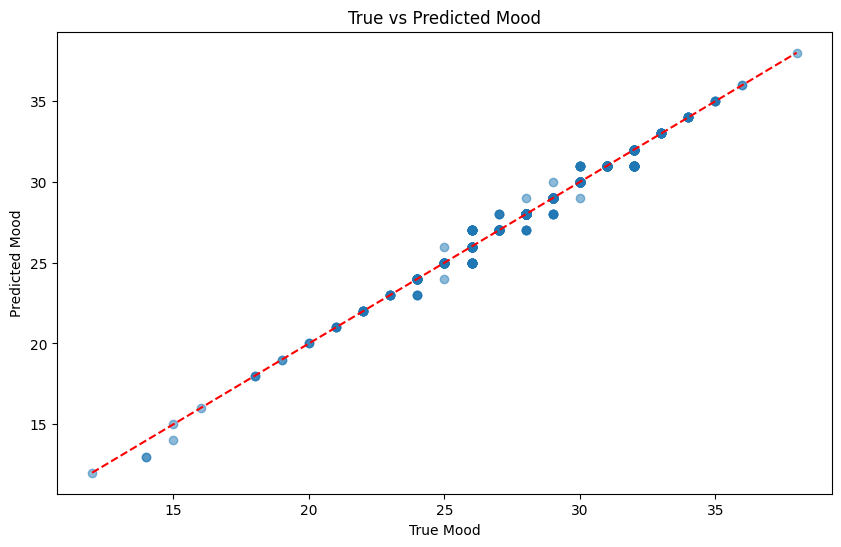

In [23]:
plot_mood_predictions(model, train_loader, device)

In [25]:
# Run predictions on test_df
test_predictions = predict(model, test_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood_class']])

         id  predicted_mood_class
0   AS14.16                    31
1   AS14.02                    25
2   AS14.12                    22
3   AS14.30                    32
4   AS14.19                    29
5   AS14.09                    29
6   AS14.29                    28
7   AS14.01                    33
8   AS14.14                    30
9   AS14.25                    28
10  AS14.07                    27
11  AS14.23                    30
12  AS14.20                    24
13  AS14.15                    33
14  AS14.17                    28
15  AS14.31                    28
16  AS14.26                    27
17  AS14.33                    29
18  AS14.13                    28
19  AS14.24                    28
20  AS14.08                    28
21  AS14.27                    28
22  AS14.32                    28
23  AS14.03                    32
24  AS14.06                    28
25  AS14.05                    30
26  AS14.28                    28


In [11]:
train_df = train_df.sort_values('mood')
train_df['mood'].unique(), train_df['mood'].value_counts()

(array([12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
        31, 32, 33, 34, 35, 36, 38], dtype=int32),
 mood
 28    301
 29    138
 32    128
 30    124
 26    103
 27     98
 31     98
 24     66
 25     65
 33     21
 22     17
 23     17
 34     13
 20      7
 35      6
 21      5
 36      4
 14      3
 18      3
 19      2
 15      2
 12      1
 16      1
 38      1
 Name: count, dtype: int64)